In [5]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, fCol, vocabType):
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = np.array(nltk.FreqDist(data[:,fCol]).most_common(5))
    major_masks = np.array([data[:,fCol] == f for (f, cnt) in major_features])
    fqs = [tweet_word_distribution(data[mask,:]) for mask in major_masks]
    return list(vocabType(data, fCol, major_features, major_masks, fqs, size))

def vocab_feature_most_common(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_feature_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(major_masks.sum(axis=0), dtype='bool')
    fq = tweet_word_distribution(data[major_mask,6]) # Get a fq over the words used by all in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary


def tweet_word_distribution(data):
    # Split each sentence into tokens, and create a frequency distribution
    tokens = [token for sentence in data[:,6] for token in sentence.split()]
    fd = nltk.FreqDist(tokens)
    return fd

### END OF VOCABULARY ###
    

# def identify_hashtags(data):
#     col = np.zeros((data.shape[0],1), 'str')
#     data = np.append(data, col, axis=1)
#     for i, text in enumerate(data[:,6]):
#         results = re.findall(r"#\w+", text) # Finds matches and returns them as an iterable
#         if results:
#             data[i,15] = ' '.join(results)
#         else:
#             data[i,15] = ''


def divide_featureset(feature):
    '''
    Divides numpy featureset of (featureVector, classification) into a 80:10:10 train:dev:test set
    '''
    testSize = int(len(feature)*0.8)
    train, rest = feature[:testSize], feature[testSize:]
    restSize = len(rest)//2
    dev, test = rest[:restSize], rest[restSize:]
    return train, dev, test


#RegEx cleaner for SKlearn (Maybe merge with Clean()).
def cleaner(text):
  stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)
  text = text.lower() #All lowercase
  text = re.sub(r'@[A-Za-z0-9]+','',text)
  text = re.sub('https?://[A-Za-z0-9./]+','', text)
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub('\W', ' ', text)
  text = re.sub('\s+', ' ', text)
  text = re.sub('b4', 'before', text)
  text = text.strip(' ')
  text = ''.join(char for char in text if char.isalpha() or char == ' ')
  text = ''.join(stemmer.stem(text)) #Stem the words using SnowballStemmer
  return text

def delete_rows(dataset, column, ID):
  """
  Takes a panda dataframe as first arg. The df column as second arg and the ID 
  as third. Returns a mask shoving only those values in the dataset.
  """
  mask = dataset[dataset[str(column)] == str(ID)]
  return mask

"""
Needs revisiting (below)
"""
# def clean(tweet):
#     stemmer = nltk.SnowballStemmer("english", ignore_stopwords=True)

#     # Remove all stopwords, non-alphabet words (except spaces), and stem the words
#     for text in tweet:
#     text = text.lower()
#     text = ''.join(char for char in tweet if char.isalpha() or char == ' ')
#     text = ' '.join(stemmer.stem(text))


"""
Needs a concrete decision on future use of the code below
"""
# def generate_features(data, vocabulary, fCol):
#     """ 
#     Creates tuples with a vector containing boolean values depending on whether
#     or not the word is in the tweet - along with the label of the tweet.
#     """
#     features = [(tweet_features(d.split(), vocabulary), c) for (d,c) in zip(data[:,6], data[:,fCol])] # column 6 is text data, column 2 is gender data
#     return features

'\nNeeds a concrete decision on future use of the code below\n'

In [6]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import nltk
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

fatal: destination path 'first-first-year-project' already exists and is not an empty directory.


In [7]:
# Using pandas to load the data file into a CSV.
# ISO-8859-1 is the encoding for tweets.
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)


#Cleaning all the text in our data with our newly build cleaner() function.
for i in range(len(data.text)):
  data.text[i] = cleaner(data.text[i])

data

,gender,Resolution_Category,text,tweet_location,tweet_state,tweet_region
0,female,Health & Fitness,newyearsresolution read more books no scrollin...,Southern California,CA,West
1,female,Humor,newyearsresolution finally master part of kitc...,New Jersey,NJ,Northeast
2,male,Personal Growth,newyearsresolution to stop being so damn perf ...,Hollywood,CA,West
3,male,Philanthropic,my newyearsresolution is to help my disabled p...,Metro NYC,NY,Northeast
4,female,Personal Growth,newyearsresolution goals bucketlist continued ü,"Pittsburgh, Pennsylvania",PA,Northeast
...,...,...,...,...,...,...
5006,female,Recreation & Leisure,tomorrow i start because and it comes highly r...,NC/TN,TN,South
5007,female,Humor,holy crap people eyes open when driving newyea...,"charleston, nyc",NY,Northeast
5008,female,Humor,rt shabby start parody of her blog nyresolutio...,Memphis,TN,South
5009,female,Career,rt to have an excellent job before or after gr...,Paris USA,TX,South


In [43]:
#Data sets 
res_data = 1

newD = delete_rows(data, "gender", "female")
newD

,gender,Resolution_Category,text,tweet_location,tweet_state,tweet_region
0,female,Health & Fitness,newyearsresolution read more books no scrollin...,Southern California,CA,West
1,female,Humor,newyearsresolution finally master part of kitc...,New Jersey,NJ,Northeast
4,female,Personal Growth,newyearsresolution goals bucketlist continued ü,"Pittsburgh, Pennsylvania",PA,Northeast
12,female,Health & Fitness,rt easy newyearsresolution stand up for your h...,New York,NY,Northeast
13,female,Personal Growth,yes let all take calculated risks and reduce s...,"New York, NY",NY,Northeast
...,...,...,...,...,...,...
5006,female,Recreation & Leisure,tomorrow i start because and it comes highly r...,NC/TN,TN,South
5007,female,Humor,holy crap people eyes open when driving newyea...,"charleston, nyc",NY,Northeast
5008,female,Humor,rt shabby start parody of her blog nyresolutio...,Memphis,TN,South
5009,female,Career,rt to have an excellent job before or after gr...,Paris USA,TX,South


In [30]:
#Splitting into test and train.
train, test = train_test_split(data,train_size=0.8, test_size=0.2, shuffle=True)
#Using Sklearn, playing around with the CountVectorizer.
vectorizer = CountVectorizer(analyzer="word", stop_words= "english",min_df= 50, binary= True)
#Create vectorized train set
X_train = vectorizer.fit_transform(train.text)
X_train.toarray()
#Create vectorized test set
X_test = vectorizer.transform(test.text)
X_test.toarray()

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
NBmodel = MultinomialNB().fit(X_train, train.tweet_region)
predicted_1 = NBmodel.predict(X_test)
np.mean(predicted_1 == test.tweet_region)

0.28614157527417744

In [35]:
print(metrics.classification_report(test.tweet_region, predicted_1))


              precision    recall  f1-score   support

     Midwest       0.24      0.03      0.06       212
   Northeast       0.18      0.01      0.03       221
       South       0.30      0.84      0.44       305
        West       0.21      0.08      0.11       265

    accuracy                           0.29      1003
   macro avg       0.23      0.24      0.16      1003
weighted avg       0.24      0.29      0.18      1003



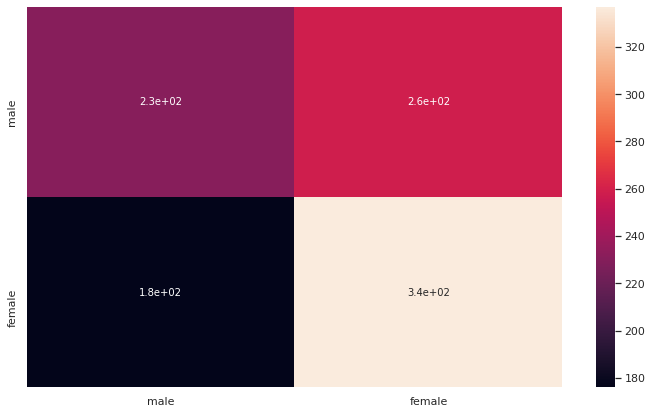

[[231 259]
 [176 337]]


In [33]:
#Creating labels for confusion matrix
categories = list()
for i in test.gender:
  if i in categories:
    pass
  else:
    categories.append(i)
# A nice confusion matrix using seaborn.
array = metrics.confusion_matrix(test.gender, predicted_1)
plt.figure(figsize=(12,7))
sn.set(font_scale=1) # for x/y label size
sn.heatmap(array, annot=True, annot_kws={"size": 10}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()
print(array)